# 3. 평가

## 정확도 = (TN + TP) / (TN + TP + FN + FP)

* 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
* 불균형한 레이블 클래스를 가지는 이진 분류 모델에서는 중점적으로 찾아야 하는 매우 적은 수의 결과값에 Positive를 설정해 1을 부여하고, 그렇지 않은 경우 Negative로 0 값을 부여하는 경우가 일반적.

1. 사기 행위 예측 모델 : 사기 행위의 경우 Positive(1), 정상 행위의 경우 Negative(0)

2. 암 예측 모델 : 암 양성의 경우 Positive(1), 음성의 경우 Negative(0)

* 불균형한 이진 분류 데이터 세트에서는 Positive 데이터 건수가 매우 작기 때문에 Negative로 예측 정확도가 높아지는 경향이 발생.

**결과적으로 정확도 지표는 비대칭한 데이터 세트에서 Positive에 대한 예측 정확도를 판단하지 못한 채 Negative에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는 수치적인 판단 오류를 일으킨다.**

### 이진 분류에서 정확도 지표가 모델의 성능을 왜곡하는 경우

#### Sex가 1이면 0, 그렇지 않으면 1로 예측하는 알고리즘

In [21]:
from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    def fit(self, x, y):
        pass
    def predict(self, x):
        pred = np.zeros((x.shape[0],1))
        for i in range(x.shape[0]):
            if x['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        
        return pred

#### EDA

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# na 처리
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    return df

# ML에 불필요한 변수 제거
def drop(df):
    df = df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1)
    return df

# 레이블 인코딩
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Sex', 'Cabin', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
    return df

# 한 번에 수행
def transform_features(df):
    df = fillna(df)
    df = drop(df)
    df = format_features(df)
    return df

#### 학습/ 예측/ 평가

In [44]:
titanic_df = pd.read_csv('C:/Users/dbswj/OneDrive/바탕 화면/train.csv')
y = titanic_df['Survived']
X = titanic_df.drop('Survived', axis = 1)
X = transform_features(X)     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

predictions = myclf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.7877094972067039


- 정확도는 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아니다.

## 오차행렬

1. TN : 예측값을 Negative(0)으로 예측하고 실제 값이 Negative(0)인 경우
2. TP : 예측값을 Positive(1)로 예측하고 실제 값이 Positive(1)인 경우
3. FN : 예측값을 Negative(0)으로 예측했는데 실제 값은 Positive(1)인 경우
4. FP : 예측값을 Positive(1)로 예측했는데 실제 값은 Negative(0)인 경우

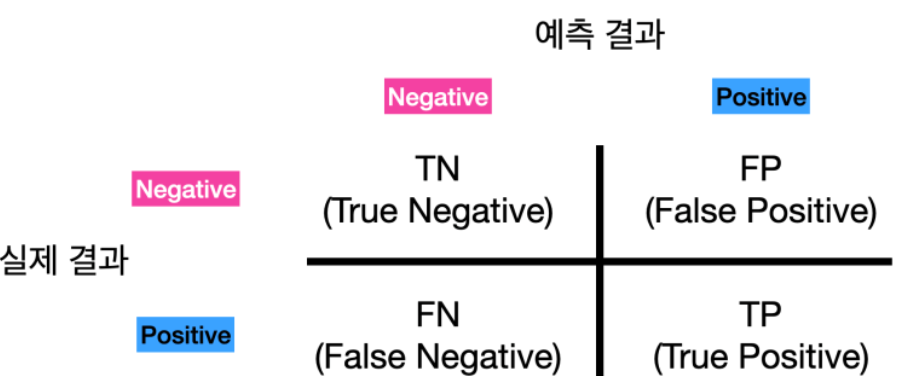

### confusion_matrix

In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predictions)

array([[92, 18],
       [20, 49]], dtype=int64)

## 정밀도와 재현율
* Positive 데이터 세트의 예측 성능에 초점을 맞춘 평가 지표.

### 정밀도 = TP / (FP + TP)
* 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율.
* Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표로 양성 예측도라고도 불림.
* 정밀도가 1에 가까워지려면 FP를 낮추어야 한다.
* 실제 Negative인 데이터를 Positive로 잘못 예측하면 큰 위험이 있는 경우 정밀도를 주요 지표로 설정
* ex) 스팸 메일

### 재현율 = TP / (FN + TP)
* 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율.
* 민감도 또는 TPR이라고도 불림.
* 재현율이 1에 가까워지려면 FN을 낮추어야 한다.
* 실제 Positive인 데이터를 Negative로 잘못 예측하면 큰 위험이 있는 경우 재현율을 주요 지표로 설정.
* ex) 암 판단 모델, 금융 사기

### titaninc data를 활용한 평가
#### 함수 설정

In [50]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

def evaluation(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test, pred)
    print(confusion)
    print(f'정확도 : {accuracy}, 정밀도 : {precision}, 재현율 : {recall}')

#### 로지스틱 회귀 분석

In [51]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)
pred = logistic_reg.predict(X_test)
evaluation(y_test, pred)

[[92 18]
 [16 53]]
정확도 : 0.8100558659217877, 정밀도 : 0.7464788732394366, 재현율 : 0.7681159420289855


### 정밀도 / 재현율 트레이드오프
* 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다.
* 정밀도 / 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한쪽을 보완하면 다른 하나의 수치는 떨어지기 쉽다. -> 트레이드오프

#### predict_proba()
* 데이터별 예측 확률을 반환
* predict() 메서드와 동일하게 보통 테스트 피처 데이터 세트를 입력
* ndarray m x n 형태로 출력. (m : 데이터 개수, n : 클래스 값 유형)
* 첫 번째 칼럼은 0(Negative)의 확률, 두 번째 칼럼은 1(Positive)의 확률
* predict()는 predict_proba() 호출 결과로 반환된 배열에서 분류 결정 임계값보다 큰 값이 들어 있는 칼럼의 위치를 받아서 예측 결정을 하는 API

In [74]:
pred_proba = logistic_reg.predict_proba(X_test)
pred_proba[:3,]

array([[0.85134009, 0.14865991],
       [0.89240431, 0.10759569],
       [0.93365967, 0.06634033]])

#### Binarizer 클래스를 이용한 임곗값 설정
* 예시

In [76]:
from sklearn.preprocessing import Binarizer

x = [[1,-1,2],
     [2,0,0],
     [0,1.1,1.2]]

binarizer = Binarizer(threshold=1.1)
binarizer.fit_transform(x)

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [98]:
# 앞에서 구한 pred_proba 변수에 임곗값을 0.5로 지정한 후 최종 예측값 추출
# Positive 칼럼만 추출해 적용

binarizer = Binarizer(threshold=0.5)
pred_05 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))
pred_05

evaluation(y_test,pred_05)

[[92 18]
 [16 53]]
정확도 : 0.8100558659217877, 정밀도 : 0.7464788732394366, 재현율 : 0.7681159420289855


In [99]:
# 앞에서 구한 pred_proba 변수에 임곗값을 0.3으로 지정한 후 최종 예측값 추출
# Positive 칼럼만 추출해 적용

binarizer = Binarizer(threshold=0.3)
pred_03 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))
pred_03

evaluation(y_test,pred_03)

[[81 29]
 [10 59]]
정확도 : 0.7821229050279329, 정밀도 : 0.6704545454545454, 재현율 : 0.855072463768116


* 정밀도가 떨어지고 재현율이 올라감
* 왜냐하면, 임곗값이 낮아져 Positive로 예측되는 수가 많아지기 때문에

### 정밀도와 재현율의 맹점
#### 정밀도가 100%가 되는 방법
* 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측
* TP / (TP + FP)
* 전체 환자 1000명 중 확실한 Positive 징후를 나타내는 환자는 1명이라고 하면 이 한 명을 Positive로 예측하고 나머지를 Negative로 예측
* 정밀도는 1 / (1 + 0) = 100%

#### 재현율이 100%가 되는 방법
* 모든 환자를 Positive로 예측
* TP/ (TP + FN)
* 전체 환자 1000명을 다 Positive로 예측. 실제 양성인 사람이 30명 존재하더라도 FN = 0
* 재현율은 30 / (30 + 0) = 100%

**분류가 정밀도 또는 재현율 중 하나에 상대적인 중요도를 부여해 각 예측 상황에 맞는 분류 알고리즘을 튜닝할 수 있지만, 하나의 지표만 강조되는 상황은 올바르지 않다.**